<a href="https://colab.research.google.com/github/shinmiura/diveintocode-ml/blob/master/TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sprintの目的**

・フレームワークを用いたコードを読めるようになる

・フレームワークを習得し続けられるようになる

・理論を知っている範囲をフレームワークで動かす

どのように学ぶか

TensorFlowのサンプルコードを元に、これまで扱ってきたデータセットを学習していきます。

# 2.コードリーディング

TensorFlowによって2値分類を行うサンプルコードを載せました。今回はこれをベースにして進めます。


tf.estimator などの高レベルAPIは使用していません。低レベルなところから見ていくことにします。



【問題1】スクラッチを振り返る

ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。


（例）


・重みを初期化する必要があった

・エポックのループが必要だった

それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。

**データセットの用意**

以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。


Iris Species


目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。

Iris-versicolor

Iris-virginica

【問題１の解答】　　ディープラーニングを実装するために必要だったもの

・　学習に時間がかかるため実装していくうえで処理のための時間を確保する必要があった。

・　構造(層の数、ユニット数など)を決める必要があった。

・　重みとバイアスをパラメータとして設定する必要があった。

・　重みとバイアスを初期化する必要があった。

・重みパラメータの勾配を求め、重みパラメータを勾配方向に微少量だけ重みの値を更新する必要があった。

・

・　順伝播だけでなく逆伝播も実装する必要があった。

・　全結合ニューラルネットワークでは行列の計算をして活性化関数を通すという処理を繰り返す必要があった。

・　各層における入力と重み付き入力を保持しておく必要があった(∵後で逆伝播と重みの更新の時に使う)

・　デルタの計算のために活性化関数を微分する必要があった

・　逆伝播の処理にあたっては、上記の活性化関数の微分のほか出力層のデルタ、隠れ層のデルタを実装する必要があった。

・逆伝播されたデルタを使って(偏微分を求めて)パラメータを更新する必要があった。

・　エポック数を（誤差を見ながら見極める)設定する必要があった。

・　学習データをミニバッチと呼ばれる小さな単位に分割して学習する必要(ミニバッチの損失関数の値を減らすことを目的)があった。



In [7]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns #バイオリン図で必要になる（seaborn ライブラリーの violinplot メソッド）
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline
# tensorflow1系
# import tensorflow as tf
# tensorflow2系
import tensorflow.compat.v1 as tf  #TensorFlow 2 で 1.x のコードを走らせるには左のコードが必要(Dyberのサンプルコードだと走らない)
tf.disable_eager_execution()

In [8]:
# データの読み込み
iris_dataset = load_iris()

# データの整形
iris_dataframe = pd.DataFrame(data = iris_dataset.data, columns = iris_dataset.feature_names)
# .target部分を抽出し、カラム名も指定する
iris_datalabel = pd.DataFrame(data = iris_dataset.target, columns = ['Species'])
# .concatを使用して列方向で結合する
df = pd.concat([iris_dataframe, iris_datalabel], axis = 1)

In [9]:
# ミニバッチクラス
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

**【問題2】スクラッチとTensorFlowの対応を考える**

以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。


それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。


《サンプルコード》


＊TensorFlow バージョン 2.4 で動作を確認済みです。



In [ ]:
#サンプルコード
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X).astype(np.float32)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.float32)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # 重みとバイアスの宣言
        self.w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]), trainable=True)
        self.w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]), trainable=True)
        self.w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]), trainable=True)
        self.b1 = tf.Variable(tf.random.normal([n_hidden1]), trainable=True)
        self.b2 = tf.Variable(tf.random.normal([n_hidden2]), trainable=True)
        self.b3 = tf.Variable(tf.random.normal([n_classes]), trainable=True)
    def call(self, x):
        """
        単純な3層ニューラルネットワーク
        """
        layer_1 = tf.add(tf.matmul(x, self.w1), self.b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, self.w2), self.b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, self.w3) + self.b3  # tf.addと+は等価である
        return layer_output
model = MyModel()

# # 最適化手法
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train(x, y):
    logits = model(x, training=True)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, logits))
    return loss

def evaluate(x, y):
    logits = model(x)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, logits))
    # 推定結果
    correct_pred = tf.equal(tf.sign(y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
    # 指標値計算
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return loss, accuracy

# 計算グラフの実行
for epoch in range(num_epochs):
    # エポックごとにループ
    total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
    total_loss = 0
    total_acc = 0
    for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
        # ミニバッチごとにループ
        with tf.GradientTape() as tape:
            loss = train(mini_batch_x, mini_batch_y)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        total_loss += loss
    loss = total_loss / n_samples
    val_loss, val_acc = evaluate(X_val, y_val)
    print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.3f}".format(epoch, loss, val_loss, val_acc))
_, test_acc = evaluate(X_test, y_test)
print("test_acc : {:.3f}".format(test_acc))

In [10]:
# データ準備
# 2値分類のため絞り込み
df2 = df[(df["Species"] == 0)|(df["Species"] == 1)]

# 説明変数と目的変数に分割
y = df2["Species"]
X = df2.loc[:, ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]

# 訓練データ/テストデータ/評価データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 正規化
X_train /= 255
X_test /= 255
X_val /= 255

In [11]:
# TensorFlowで学習
# 各種変数定義
learning_rate = 0.01
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 記録
        train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: y_train})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        # 仮定出力
        print("Epoch {}, train_loss : {:.4f}, val_loss : {:.4f}, train_acc : {:.3f}, val_acc : {:.3f}".format(epoch, train_loss, val_loss, train_acc, val_acc))
    
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    #prediction = sess.run(logits, feed_dict={X: X_test, Y: y_test})
    #print(prediction)
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, train_loss : 5.9152, val_loss : 7.8665, train_acc : 0.531, val_acc : 0.375
Epoch 1, train_loss : 1.3632, val_loss : 1.0122, train_acc : 0.469, val_acc : 0.625
Epoch 2, train_loss : 1.4577, val_loss : 1.9132, train_acc : 0.531, val_acc : 0.375
Epoch 3, train_loss : 1.7290, val_loss : 1.2583, train_acc : 0.469, val_acc : 0.625
Epoch 4, train_loss : 0.6383, val_loss : 0.7484, train_acc : 0.531, val_acc : 0.375
Epoch 5, train_loss : 0.5594, val_loss : 0.5968, train_acc : 0.766, val_acc : 0.750
Epoch 6, train_loss : 0.8380, val_loss : 0.6483, train_acc : 0.469, val_acc : 0.625
Epoch 7, train_loss : 0.8681, val_loss : 0.6632, train_acc : 0.469, val_acc : 0.625
Epoch 8, train_loss : 0.6439, val_loss : 0.5216, train_acc : 0.469, val_acc : 0.625
Epoch 9, train_loss : 0.5902, val_loss : 0.4847, train_acc : 0.469, val_acc : 0.625
Epoch 10, train_loss : 0.6312, val_loss : 0.4993, train_acc : 0.469, val_acc : 0.625
Epoch 11, train_loss : 0.6672, val_loss : 0.5145, train_acc : 0.469, val_ac

# 3.他のデータセットへの適用

これまで扱ってきた小さなデータセットが他にもいくつかあります。上記サンプルコードを書き換え、これらに対して学習・推定を行うニューラルネットワークを作成してください。


Iris（3種類すべての目的変数を使用）
House Prices

どのデータセットも train, val, test の3種類に分けて使用してください。

**【問題3】3種類すべての目的変数を使用したIrisのモデルを作成**

Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類すべてを分類できるモデルを作成してください。


Iris Species


2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。


《ヒント》


以下の2箇所は2クラス分類特有の処理です。

loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

メソッドは以下のように公式ドキュメントを確認してください。


tf.nn.sigmoid_cross_entropy_with_logits  |  TensorFlow


tf.math.sign  |  TensorFlow


＊tf.signとtf.math.signは同じ働きをします。

In [12]:
# データ準備
# 説明変数と目的変数に分割
y = df["Species"]
X = df.loc[:, ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]

# 訓練データ/テストデータ/評価データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

# 正規化
X_train /= 255
X_test /= 255
X_val /= 255

In [13]:
# Tensorflowで学習
# 各種変数定義
learning_rate = 0.01
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3 # 2値分類からの変更箇所

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits)) # 2値分類からの変更箇所
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1)) # 2値分類からの変更箇所
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 記録
        train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: y_train_one_hot})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val_one_hot})
        # 仮定出力
        print("Epoch {}, train_loss : {:.4f}, val_loss : {:.4f}, train_acc : {:.3f}, val_acc : {:.3f}".format(epoch, train_loss, val_loss, train_acc, val_acc))
    
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    #prediction = sess.run(logits, feed_dict={X: X_test, Y: y_test})
    #print(prediction)
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, train_loss : 8.0341, val_loss : 8.2610, train_acc : 0.302, val_acc : 0.292
Epoch 1, train_loss : 1.5219, val_loss : 1.5577, train_acc : 0.312, val_acc : 0.292
Epoch 2, train_loss : 2.0978, val_loss : 2.1565, train_acc : 0.312, val_acc : 0.292
Epoch 3, train_loss : 1.5079, val_loss : 1.5401, train_acc : 0.312, val_acc : 0.292
Epoch 4, train_loss : 1.8299, val_loss : 1.8574, train_acc : 0.323, val_acc : 0.333
Epoch 5, train_loss : 1.8376, val_loss : 1.8487, train_acc : 0.323, val_acc : 0.333
Epoch 6, train_loss : 1.7022, val_loss : 1.7070, train_acc : 0.323, val_acc : 0.333
Epoch 7, train_loss : 1.6048, val_loss : 1.6091, train_acc : 0.323, val_acc : 0.333
Epoch 8, train_loss : 1.5605, val_loss : 1.5653, train_acc : 0.323, val_acc : 0.333
Epoch 9, train_loss : 1.5391, val_loss : 1.5439, train_acc : 0.323, val_acc : 0.333
Epoch 10, train_loss : 1.5185, val_loss : 1.5225, train_acc : 0.323, val_acc : 0.333
Epoch 11, train_loss : 1.4897, val_loss : 1.4925, train_acc : 0.323, val_ac

**【問題4】House Pricesのモデルを作成**

回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。


House Prices: Advanced Regression Techniques


この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。


分類問題と回帰問題の違いを考慮してください。

In [21]:
%pwd

'/content'

In [28]:
%cd Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [29]:
%ls

 シンプソン/
 13_クラスとインスタンス.ipynb
 15_クラス変数とメンバ変数.ipynb
 16_クラスの使い道.ipynb
 Chapter1.ipynb
 Chapter2.ipynb
 CIFAR10_transfer_learning.ipynb
'CNN_intro (1).ipynb'
 CNN_intro_answer.ipynb
 CNN_intro.ipynb
 data_handling_practice_answer.ipynb
 deep-learning-from-scratch-2-master/
 deep-learning-from-scratch-master/
 def関数練習.ipynb
'example_answer_week3_sinyo_joho (1).ipynb'
 example_answer_week3_sinyo_joho.ipynb
'example_answer_week4_ayame (1).ipynb'
 example_answer_week4_ayame.ipynb
 example_answer_week4_jutaku_price.ipynb
 example_answer_week4_shinyo_joho.ipynb
'Faster R-CNNとYOLOv3_Sprint17.ipynb'
 H2O_for_preparation.ipynb
 H2O_walk_through.ipynb
 homework2_transfer_learning_answer.ipynb
 homework2_transfer_learning.ipynb
 クラスタリング.ipynb
 クラスとインスタンス.ipynb
 ニューラルネットワーク.ipynb
 ディープニューラルネットワーク.ipynb
'janome_practice_NLP (1).ipynb'
 janome_practice_NLP.ipynb
 Keras.ipynb
 Keras入門.ipynb
 Linear_regression.ipynb
'MEF_Sprint18_make_dataset（受講生用） (1).ipynb'
 MEF_Sprint18_make_dataset（受講生用）.ipynb


In [30]:
# データ準備
dataset_path ="train.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

Epoch 0, loss : 42093588.0000, val_loss : 45590244.0000
Epoch 1, loss : 4063574.2500, val_loss : 3944413.5000
Epoch 2, loss : 2199407.0000, val_loss : 1608078.5000
Epoch 3, loss : 1557475.1250, val_loss : 983844.1875
Epoch 4, loss : 1108524.3750, val_loss : 618920.6250
Epoch 5, loss : 812410.9375, val_loss : 395131.0000
Epoch 6, loss : 633375.7500, val_loss : 274056.4062
Epoch 7, loss : 511166.2500, val_loss : 201111.8594
Epoch 8, loss : 426317.8750, val_loss : 157358.0312
Epoch 9, loss : 357845.2500, val_loss : 125864.7344


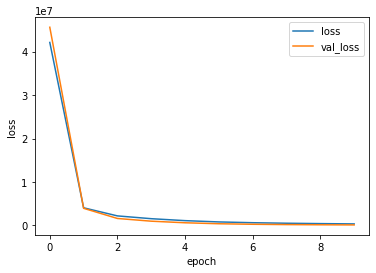

test_mse : 276948.562


In [31]:
# tensorflowで学習
# 各種変数定義
learning_rate = 0.001
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op =  tf.losses.mean_squared_error(labels=Y, predictions=logits)
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 損失記録用リスト
    loss_list = []
    val_loss_list = []
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 損失計算と格納
        loss = sess.run(loss_op, feed_dict={X: X_train, Y: y_train})
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        loss_list.append(loss)
        val_loss_list.append(val_loss)    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
    
    # 学習過程可視化
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()
    # テストデータに適用
    test_loss = sess.run(loss_op, feed_dict={X: X_test, Y: y_test})
    print("test_mse : {:.3f}".format(test_loss))

**【問題5】MNISTのモデルを作成**

ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。


3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。


スクラッチで実装したモデルの再現を目指してください。

In [32]:
# データ準備
# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#　平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 変形
y_train = y_train.astype(np.int)[:, np.newaxis]
y_test = y_test.astype(np.int)[:, np.newaxis]

# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:])
y_test_one_hot = enc.fit_transform(y_test[:])

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

11501568/11490434 [==============================] - 0s 0us/step


In [33]:
# tensorflowで学習
# 各種変数定義
learning_rate = 0.003
batch_size = 1
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10 # 2値分類からの変更箇所

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train[:1000], y_train[:1000], batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits)) # 2値分類からの変更箇所
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1)) # 2値分類からの変更箇所
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 記録
        train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: y_train})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        # 仮定出力
        print("Epoch {}, train_loss : {:.4f}, val_loss : {:.4f}, train_acc : {:.3f}, val_acc : {:.3f}".format(epoch, train_loss, val_loss, train_acc, val_acc))
    
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    #prediction = sess.run(logits, feed_dict={X: X_test, Y: y_test})
    #print(prediction)
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, train_loss : 44.5134, val_loss : 44.5732, train_acc : 0.594, val_acc : 0.592
Epoch 1, train_loss : 28.3701, val_loss : 28.2233, train_acc : 0.702, val_acc : 0.702
Epoch 2, train_loss : 28.0623, val_loss : 28.0069, train_acc : 0.715, val_acc : 0.712
Epoch 3, train_loss : 24.4618, val_loss : 24.4489, train_acc : 0.739, val_acc : 0.731
Epoch 4, train_loss : 21.7868, val_loss : 21.6349, train_acc : 0.767, val_acc : 0.760
Epoch 5, train_loss : 23.4652, val_loss : 23.6872, train_acc : 0.764, val_acc : 0.760
Epoch 6, train_loss : 22.6102, val_loss : 22.6563, train_acc : 0.784, val_acc : 0.776
Epoch 7, train_loss : 28.2148, val_loss : 28.9051, train_acc : 0.755, val_acc : 0.750
Epoch 8, train_loss : 22.7048, val_loss : 23.0438, train_acc : 0.790, val_acc : 0.787
Epoch 9, train_loss : 20.1201, val_loss : 20.3763, train_acc : 0.808, val_acc : 0.803
Epoch 10, train_loss : 22.2948, val_loss : 21.9325, train_acc : 0.807, val_acc : 0.804
Epoch 11, train_loss : 24.4859, val_loss : 24.2685, t